<a href="https://colab.research.google.com/github/aromanenko/DSCS/blob/main/DSCS_7_Unsupervised_Analtics_in_SC_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HSE, DSCS. Analytics in Retail Chain, Fall 2025

<font color="green"> Lesson #2: Unsupervised learning tasks in Retail </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:**
    - Time Series Segmentation, TS Clustering, Intermittency Test, Seasonality Test, ABC-classification
    
**Your feedback:**  please provide you feedback  <a href="https://forms.gle/FRaq6t8kKTdLoDws8"> here </a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# don't forget to upload utils file to the colab session
import warnings

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
# import seaborn as sns
# sns.set_style("darkgrid")
# pd.plotting.register_matplotlib_converters()
# Default figure size

from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

# Clustering based on Demand Behaviour to define ML Training pipeline
**Question:** How to split all timeseries with about the same structure?

*Idea: apply clustering algorithms to lagged features.



In [3]:
# Loading data
ts_retail = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_2products.csv', sep=';')
ts_retail['Date'] = pd.to_datetime(ts_retail['Date'], format= "%Y-%m-%d") #dayfirst=True)
ts_retail.set_index(['Date'], inplace=True)
ts_retail = ts_retail.sort_index() # must have
ts_retail.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22.0,163.78,NaN
2015-01-01,19,1,NaN,25.0,163.78,NaN
2015-01-01,39,2,NaN,3.0,135.78,NaN
2015-01-01,40,2,NaN,0.0,135.78,NaN
2015-01-01,18,1,NaN,13.0,163.78,NaN


In [4]:
ts_retail['SKU_id'].unique()

array([1, 2])

In [ ]:
# create learing sample for clusterization
demand_top_sku_pivot = pd.pivot_table(ts_retail.groupby(['SKU_id', 'Store_id']).mean()['Demand'].reset_index(),
                                      index='Store_id', values='Demand', columns='SKU_id', fill_value=0).rename_axis(None, axis=1)
demand_top_sku_pivot

,1,2
Store_id,,
1,260.531496,14.726378
2,625.015748,19.470472
3,378.708661,9.431102
4,422.751969,10.895669
5,570.673228,18.431102
...,...,...
99,378.585106,7.500000
100,173.166667,22.333333
104,188.791667,4.291667


In [5]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

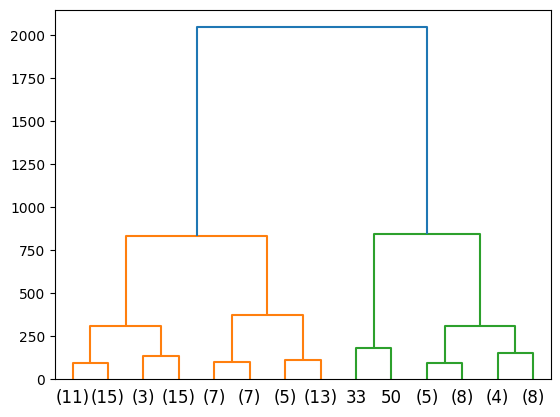

In [6]:
# for SKU in ts_retail['SKU_id'].unique():
# select TOP SKU (in case there are a lot of SKU)
top_sum = ts_retail.groupby('SKU_id').sum()[['Demand']]
top_sum['percent'] = top_sum['Demand']/top_sum['Demand'].sum()
top_SKU = list((top_sum['percent'] >= 0.01).index)
demand_top_sku = ts_retail[[ SKU in top_SKU for SKU in ts_retail['SKU_id'] ]]

demand_top_sku_pivot = pd.pivot_table(demand_top_sku.groupby(['SKU_id', 'Store_id']).mean()['Demand'].reset_index(),
                                      index='Store_id', values='Demand', columns='SKU_id', fill_value=0).rename_axis(None, axis=1)


# Select Clustering method: tbd, e.g. AgglomerativeClustering
agcl =  AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agcl = agcl.fit(demand_top_sku_pivot)
# plot the top three levels of the dendrogram
plot_dendrogram(agcl, truncate_mode="level", p=3)

In [10]:
N_CLUSTERS = 2 # number of custers can be defined using dendrogram
agcl =  AgglomerativeClustering(n_clusters=N_CLUSTERS)
cluster_labels = agcl.fit_predict(demand_top_sku_pivot)
# cluster_labels = cluster_labels
# clustered_store = pd.DataFrame(cluster_labels, index=demand_top_sku_pivot.index, columns=['cluster_label'])

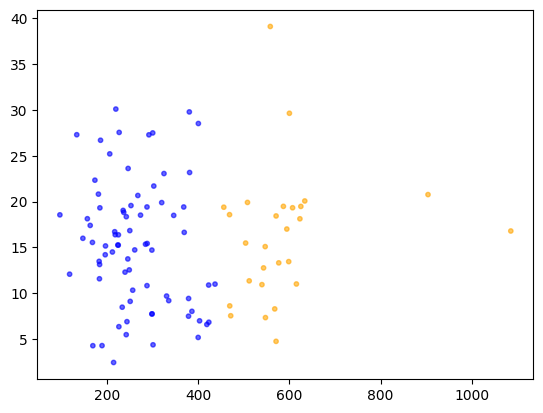

In [11]:
# plot clusters
colors = ['orange','blue', 'red', 'green']
plt.scatter(demand_top_sku_pivot[1], demand_top_sku_pivot[2], c=[colors[x] for x in cluster_labels], alpha = 0.6, s=10)

# TS Segmentation to define TS-Forecasting Pipeline


**Question**
 * What is the main reason of overfitting problem?
   <!-- Too big complexity of the algorithm. -->
 * Can you describe complexity of ESM/ARIMA/Intermittent Models?
    <!-- The more hidden components including drivers we need to estimate by the algorithm the more complicated the algorithm is. -->
 * Is it possible to decrease complexity of train ts-algorithm assuming that we use all known models in the training process ESM/ARIMA/Intermittent models?
  <!-- Idea: let's exclude excessive models from training set of models -->

  ## One more way how to select ts-models family before training process

<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/ts_pipeline_segmentation.png?raw=true' width = 800pt>

**Правило сопоставления сегмента TS и семейства моделей, учесвующих в обучении**

|   Сегмент     |   Семейство алгоритмов   |
|-------------------------|----------------|
|RETIRED                               |zero-model (прогноз =0)|
|LOW_VOLUME                           |Simple ES|
|INSEASON_NON_INTERMITTENT|           Seasonal ES and ARIMA|
|INSEASON_INTERMITTENT    |         Croston model|
|YEAR_ROUND_SEASONAL                   |Seasonal ES and ARIMA|
|YEAR_ROUND_SEASONAL_INTERMITTENT      |Croston Model|
|YEAR_ROUND_NOT_SEASONAL               |not-seasonal ES annd ARIMA|
|YEAR_ROUND_INTERMITTENT                |Croston Model|
|Short                |ML (out of the scope)|

Detailes see here: https://github.com/aromanenko/ts-segmentation

# Building Forecastability Index
Those Time Series that have about the same accuracy level should have the same $\color{red}{Forecastability~Index}$.



<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/Forecastability%20Index.png?raw=true' width = 500pt>

Techniques to do it
* STL decomposition (detecting trend and seasonality) https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html

* ABC splitting (to segment by Demand Velocity and Demand Variability) https://pypi.org/project/abc-analysis/
or <a href = 'https://excel.city/2015/01/methods-of-classification-in-abc-analysis/'>more advanced tecniques </a>

* Intermittency time series tests
 Detailes see here: https://github.com/tomasmor42/timeseries_segmentation


In [12]:
!pip install abc_analysis

In [16]:
a_set
# .cumsum()

,0,cumsum
2,25,0.247525
10,22,0.465347
3,17,0.633663
1,15,0.782178
7,6,0.841584
6,5,0.891089
9,3,0.920792
5,3,0.950495
4,2,0.970297
8,2,0.990099


In [19]:
# how to build cumulative curve
a_set = pd.DataFrame([1, 15, 25, 17, 2, 3, 5, 6, 2, 3, 22])
a_set.sort_values(by = 0, ascending = False, inplace = True) # descending sort
a_set['cumsum'] = a_set.cumsum()/a_set.sum() # nomalized cumulative plot == cdf
a_set.reset_index()['cumsum'].plot(title = 'Cumulative sum of values') # plot the curve

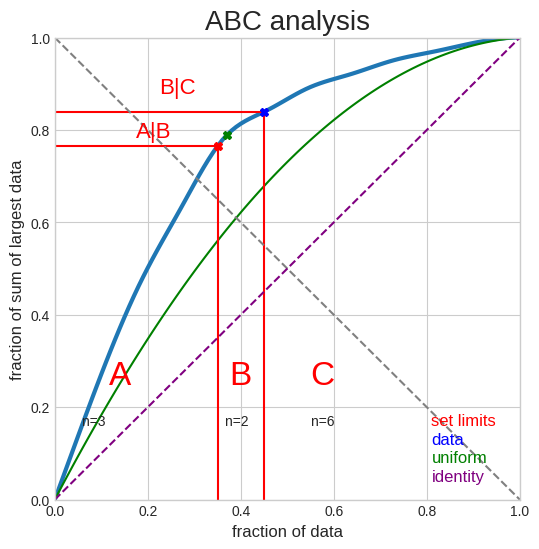

In [20]:
import abc_analysis
from abc_analysis import abc_analysis, abc_plot

# Perform an ABC analysis with plotting
dctAnalysis = abc_analysis([1, 15, 25, 17, 2, 3, 5, 6, 2, 3, 22], True)

In [21]:
# let's look at each pair store-sku separetely
ts_id_columns = ['Store_id', 'SKU_id']
ts_retail.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22.0,163.78,NaN
2015-01-01,19,1,NaN,25.0,163.78,NaN
2015-01-01,39,2,NaN,3.0,135.78,NaN
2015-01-01,40,2,NaN,0.0,135.78,NaN
2015-01-01,18,1,NaN,13.0,163.78,NaN


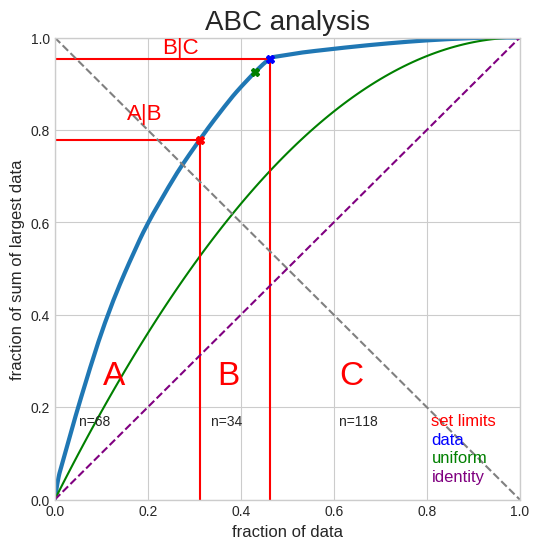

In [22]:
# split TS by Demand Volume
ts_mean_values = ts_retail.groupby(ts_id_columns)['Demand'].mean()

# plot saved results of an ABC analysis
ts_demand_abc  = abc_analysis(ts_mean_values.fillna(0), True)


In [23]:
# let's have a look at abc results structure
ts_demand_abc['Aind']

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 24,
 28,
 30,
 32,
 36,
 38,
 44,
 46,
 50,
 54,
 56,
 62,
 64,
 66,
 68,
 70,
 72,
 74,
 76,
 78,
 82,
 84,
 86,
 88,
 90,
 92,
 94,
 100,
 102,
 106,
 108,
 112,
 114,
 116,
 124,
 128,
 130,
 132,
 134,
 136,
 138,
 140,
 142,
 154,
 156,
 158,
 164,
 166,
 172,
 176,
 178,
 180,
 184,
 186,
 188,
 190,
 194,
 196]

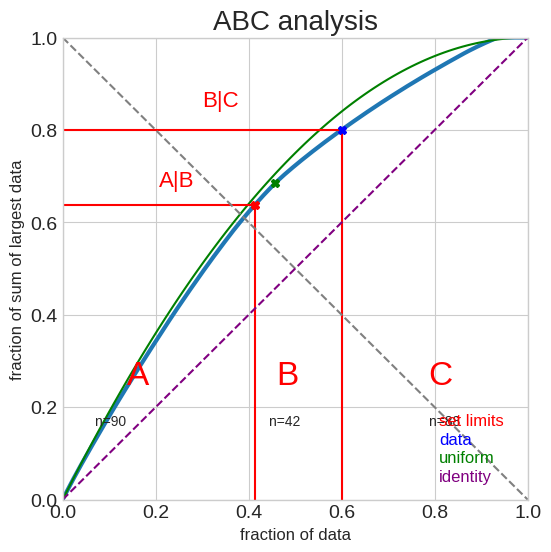

In [ ]:
# split TS by Coefficient of Volatility (CV)
ts_cv_values = ts_retail.groupby(ts_id_columns)['Demand'].std().div(ts_retail.groupby(ts_id_columns)['Demand'].mean().fillna(1))

# Plot saved results of an ABC analysis
ts_demand_abc  = abc_analysis(ts_cv_values.fillna(0), True)

In [ ]:
# one more idea: let's run abc-analysis for non-promo days only
idx = ts_retail['Promo'].fillna(0)==0
(ts_retail[idx &(ts_retail['SKU_id']==1) & (ts_retail.Store_id==1)][['Demand']]).merge(
 ts_retail[~idx &(ts_retail['SKU_id']==1) & (ts_retail.Store_id==1)][['Demand']], how='outer', right_index = True, left_index = True).plot()

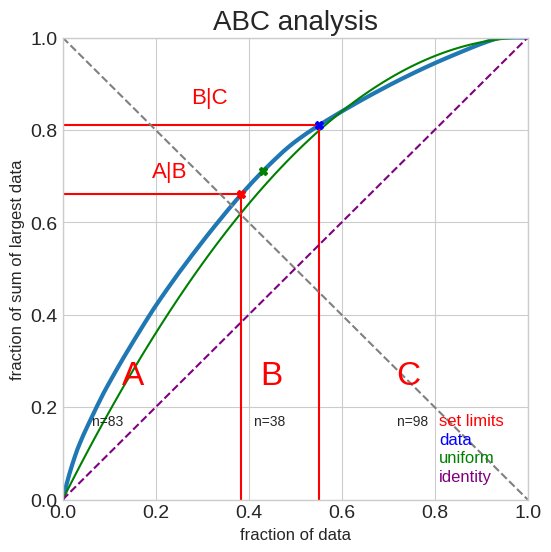

In [ ]:
# split TS by Coefficient of Volatility (CV)
idx = ts_retail['Promo'].fillna(0)==0
ts_cv_values = ts_retail[idx].groupby(ts_id_columns)['Demand'].std().div(ts_retail[idx].groupby(ts_id_columns)['Demand'].mean().fillna(1))

# abc-analysis looks more appropriate
# there are only 2 groups (not 3)
ts_demand_abc  = abc_analysis(ts_cv_values.fillna(0), True)

In [ ]:
# you can observe also that there is no multimodal distribution in it
ts_cv_values.hist(bins = 100)

# Conclusion

* TS segmentation can be done by many different approaches
  - Building of ML models dimensions can be perfomed with Clustering algorithms
  - Building of Forecastability groups can be done with some conservative segmentation techniques

* ABC-analysis is very usefull methods in many business areas
  - it helps alse to split items for building Forecastability Index
  